In [132]:
import pandas as pd
import re
import emoji
import dateutil.parser
from tqdm.notebook import tqdm, trange
import time 
import matplotlib.pyplot as plt
import numpy as np

84908


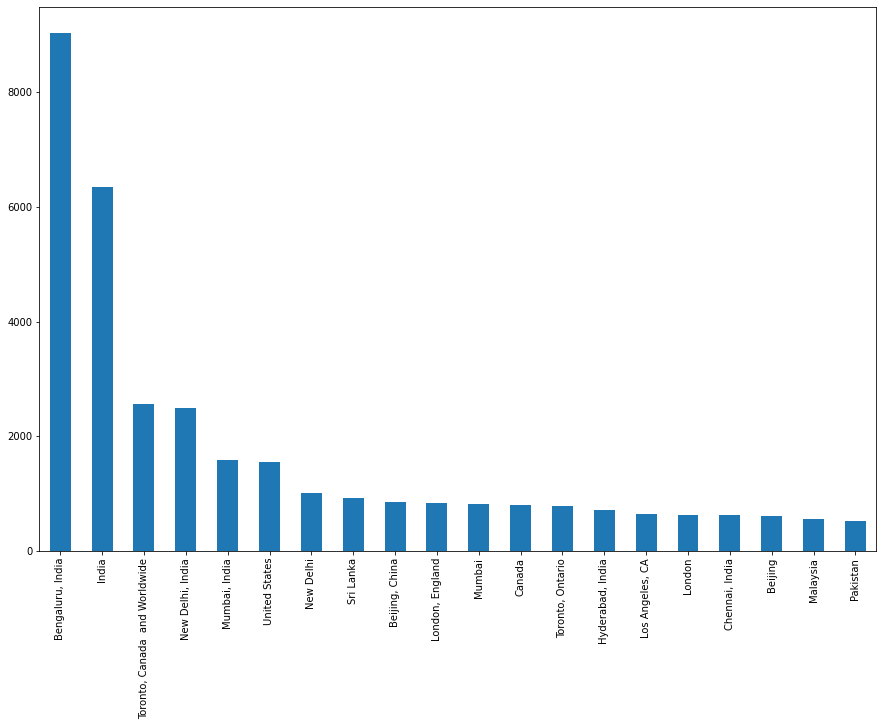

In [90]:
#Reading the file
tweet_data = pd.read_csv( 'vaccination_all_tweets.csv' )

#Dropping tweets that don't have location
tweet_data = tweet_data.dropna(axis = 0, subset = ['user_location'])

# Visulizing Tweet Count vs Location  
plt.figure(figsize=(15,10))
tweet_data['user_location'].value_counts().nlargest(20).plot(kind='bar')

#Removing rows that don't have names that relate to USA
tweet_data_filtered = tweet_data[tweet_data['user_location'].str.find('ndia') == -1] 
tweet_data_filtered = tweet_data_filtered[tweet_data_filtered['user_location'].str.find('stan') == -1]
tweet_data_filtered = tweet_data_filtered[tweet_data_filtered['user_location'].str.find('anka') == -1]
tweet_data_filtered = tweet_data_filtered[tweet_data_filtered['user_location'].str.find('desh') == -1]
tweet_data_filtered = tweet_data_filtered[tweet_data_filtered['user_location'].str[-1] != 'i']

print(len(tweet_data_filtered))
tweet_data = tweet_data_filtered

In [91]:
#Removing columns that are not necessary
tweet_data = tweet_data.drop( 
                             axis = 1 , 
                             columns = ['id', 'user_name', 'user_location', 'user_description', 'user_created', 
                                        'user_followers', 'user_friends', 'user_favourites',
                                        'user_verified', 'hashtags', 'source', 'is_retweet', 'retweets', 'favorites']
                             )
display(tweet_data.head())

,date,text
0,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...
1,2020-12-13 16:27:13,While the world has been on the wrong side of ...
2,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're..."
5,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...


#### Importing various libraries

In [92]:
#SpaCy
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

#Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [93]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

In [94]:
analyzer = SentimentIntensityAnalyzer()
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [95]:
text1 = 'This covid situation is getting out of hand!'

print(classifier(text1))
print(analyzer.polarity_scores(text1))
doc = nlp(text1)
print(doc._.polarity)

text2 = 'This govt has failed miserably in handline of COVID-19!'

print(classifier(text2))
print(analyzer.polarity_scores(text2))
doc = nlp(text2)
print(doc._.polarity)


[{'label': 'NEGATIVE', 'score': 0.99717777967453}]
{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.5411}
0.0
[{'label': 'NEGATIVE', 'score': 0.9990795850753784}]
{'neg': 0.489, 'neu': 0.511, 'pos': 0.0, 'compound': -0.7712}
-0.75


In [102]:
date_sentiment_list = []
print(len(tweet_data))
count = 0

for i in tqdm(tweet_data.iterrows()):
    count+=1
    #print(count)
    if(count % 1000 == 0):
        date_sentiment_df = pd.DataFrame(date_sentiment_list, columns = ['Date','vaderSentiment', 'BERTSentiment', 'SpaCySentiment'])
        date_sentiment_df.to_csv('cachedOutPutVaccine_'+str(count)+'_.csv', index = False)
    
    date_sentiment = []
    
    tweet = i[1]['text']
    date = i[1]['date']
    
    #Removing Emojis
    tweet = emoji.get_emoji_regexp().sub(r'', tweet)
    #Removing the urls from the tweet 
    tweet = re.sub(r'http\S+', '', tweet)
    #Removing all special chars
    tweet = re.sub('[^A-Za-z0-9]',' ',tweet)
    
#    date_day = dateutil.parser.parse(date[:10])
    date_sentiment.append(date[:10])
    
    #Getting the VaderScore
    vader_score = analyzer.polarity_scores(tweet)
    vader_positive = vader_score['pos']
    vader_negative = vader_score['neg']
    date_sentiment.append(vader_positive - vader_negative)
    
    #Getting BERT Score
    bert_sentiment = classifier(tweet)
    if(bert_sentiment[0]['label'] == 'NEGATIVE'):
        bert_score = bert_sentiment[0]['score'] * (-1)
    else:
        bert_score = bert_sentiment[0]['score']
    date_sentiment.append(bert_score)
    
    #Getting SpaCy score
    doc = nlp(tweet)
    date_sentiment.append(doc._.polarity)

    date_sentiment_list.append(date_sentiment)
    


84908


0it [00:00, ?it/s]

In [103]:
date_sentiment_df = pd.DataFrame(date_sentiment_list, columns = ['Date','vaderSentiment', 'BERTSentiment', 'SpaCySentiment'])
date_sentiment_df.to_csv('cachedOutPutVaccine_.csv', index = False)

In [104]:
date_sentiment_df.head()

,Date,vaderSentiment,BERTSentiment,SpaCySentiment
0,2020-12-20,0.213,-0.994333,0.00
1,2020-12-13,-0.016,0.977868,-0.50
2,2020-12-12,0.118,-0.989733,0.00
3,2020-12-12,0.000,0.993880,-0.05
4,2020-12-12,0.293,-0.999029,0.40


In [134]:
pd.options.plotting.backend = "plotly"

In [130]:
august_df = date_sentiment_df[date_sentiment_df['Date'].str.find('2021-08') != -1]
display(august_df.head())
print(len(august_df))
decJanFeb_df = date_sentiment_df[(date_sentiment_df['Date'].str.find('2020-12') != -1) | 
                                (date_sentiment_df['Date'].str.find('2021-01') != -1) |
                                (date_sentiment_df['Date'].str.find('2021-02') != -1) ]
display(decJanFeb_df.head())
print(len(decJanFeb_df))

,Date,vaderSentiment,BERTSentiment,SpaCySentiment
71147,2021-08-02,0.000,-0.961825,0.0
71240,2021-08-02,-0.200,-0.998931,0.0
71241,2021-08-01,-0.217,-0.998714,0.0
71242,2021-08-01,-0.200,-0.998470,0.0
71243,2021-08-01,0.216,-0.959460,0.0


11926


,Date,vaderSentiment,BERTSentiment,SpaCySentiment
0,2020-12-20,0.213,-0.994333,0.00
1,2020-12-13,-0.016,0.977868,-0.50
2,2020-12-12,0.118,-0.989733,0.00
3,2020-12-12,0.000,0.993880,-0.05
4,2020-12-12,0.293,-0.999029,0.40


10896


In [146]:
date_sentiment_df = date_sentiment_df.sort_values(by=['Date'])
start_date = date_sentiment_df.iloc[0]['Date']
day_sentiment_list = []
bertSentiment = 0
spacySentiment = 0
vaderSentiment = 0
days_count = 1
for i in range(1,len(date_sentiment_df)):
    curr_date = date_sentiment_df.iloc[i]['Date']
    if(curr_date == start_date):
        days_count += 1
        bertSentiment += date_sentiment_df.iloc[i]['BERTSentiment']
        spacySentiment += date_sentiment_df.iloc[i]['vaderSentiment']
        vaderSentiment += date_sentiment_df.iloc[i]['SpaCySentiment']
    else:
        day_sentiment = []
        day_sentiment.append(start_date)
        day_sentiment.append(bertSentiment/days_count)
        day_sentiment.append(spacySentiment/days_count)
        day_sentiment.append(vaderSentiment/days_count)
        day_sentiment_list.append(day_sentiment)
        
        start_date = curr_date
        days_count = 1
        
        bertSentiment = date_sentiment_df.iloc[i]['BERTSentiment']
        spacySentiment = date_sentiment_df.iloc[i]['vaderSentiment']
        vaderSentiment = date_sentiment_df.iloc[i]['SpaCySentiment']
    
day_sentiment_df = pd.DataFrame(day_sentiment_list, columns = ['Date','BERTSentiment', 'vaderSentiment', 'SpaCySentiment'])

,BERTSentiment,vaderSentiment,SpaCySentiment
count,28.000000,28.000000,28.000000
mean,-0.517098,0.041213,0.094086
std,0.094381,0.018879,0.036624
min,-0.774065,-0.011310,0.048500
25%,-0.566082,0.034188,0.073033
50%,-0.501737,0.047167,0.086305
75%,-0.465654,0.050878,0.106983
max,-0.337664,0.073223,0.244990


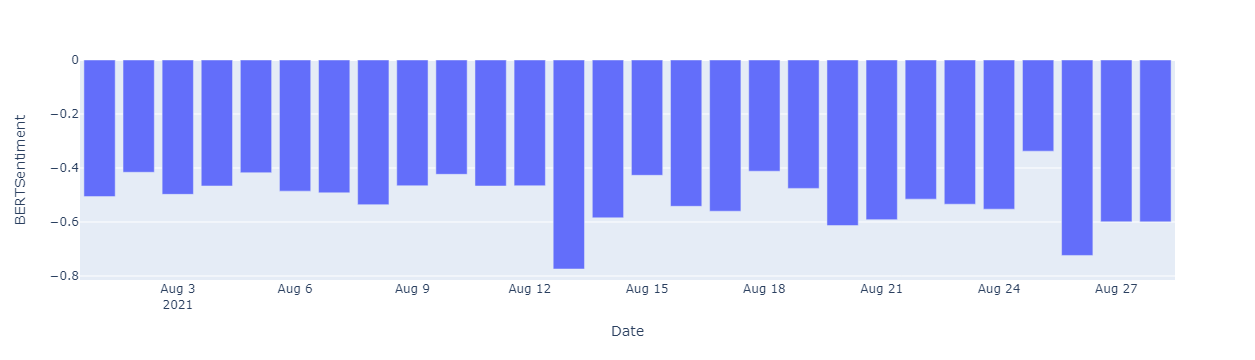

,BERTSentiment,vaderSentiment,SpaCySentiment
count,28.000000,28.000000,28.000000
mean,-0.431185,0.046797,0.103677
std,0.100209,0.017232,0.016468
min,-0.759450,0.015148,0.072113
25%,-0.474944,0.037947,0.094478
50%,-0.432928,0.046097,0.101204
75%,-0.384686,0.054693,0.113971
max,-0.188430,0.109429,0.147371


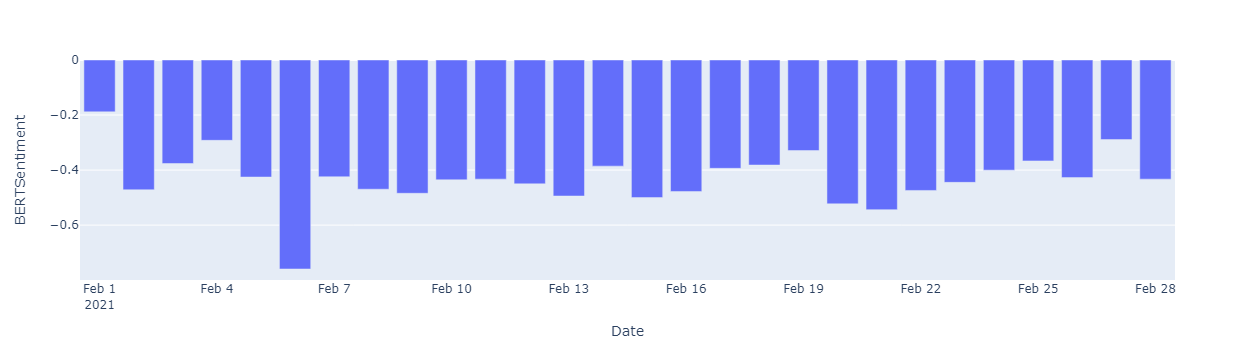

In [155]:
#display(day_sentiment_df.head())

august_df = day_sentiment_df[day_sentiment_df['Date'].str.find('2021-08') != -1]
display(august_df.describe())
fig = august_df.plot.bar(x="Date", y="BERTSentiment")
fig.show()

# decJanFeb_df = day_sentiment_df[(day_sentiment_df['Date'].str.find('2021-01') != -1) |
#                                 (day_sentiment_df['Date'].str.find('2021-02') != -1) ]
feb_df = day_sentiment_df[day_sentiment_df['Date'].str.find('2021-02') != -1]
display(feb_df.describe())
fig = feb_df.plot.bar(x="Date", y="BERTSentiment")
fig.show()

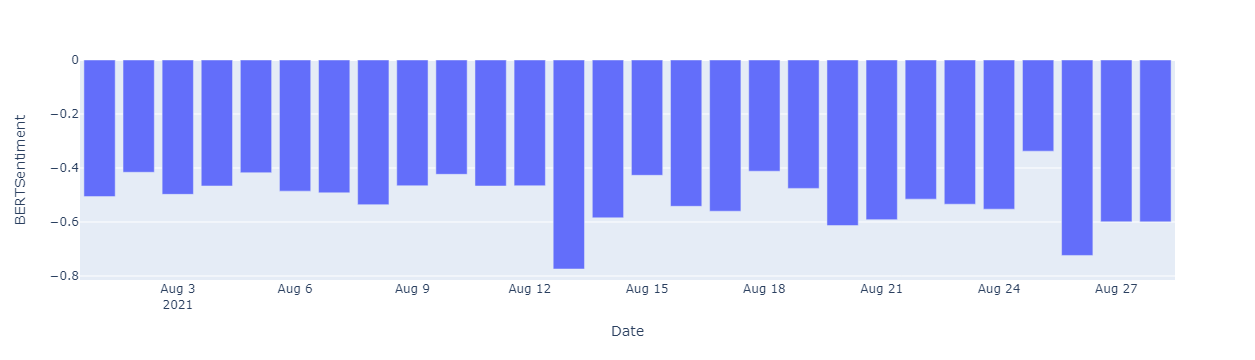

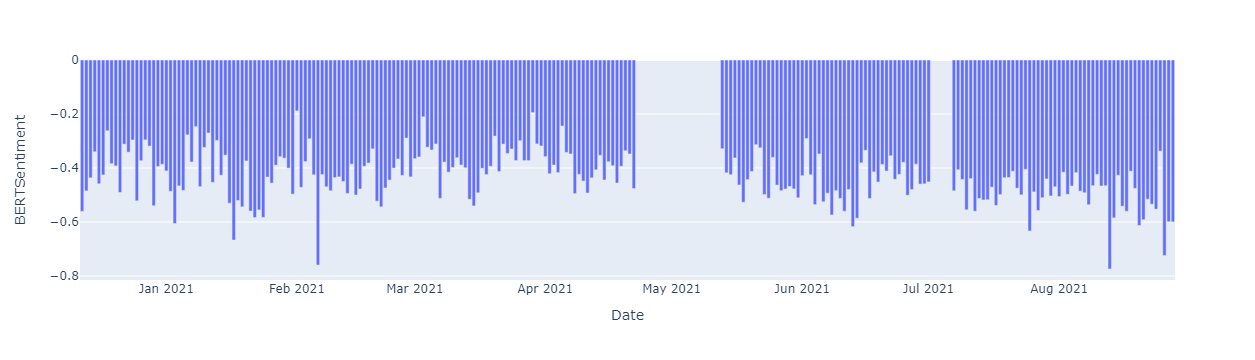